In [1]:
# Load segmentation mask
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import h5py
import torch
print(os.getpid())
plt.style.use('dark_background')


2077573


In [2]:
# ChromAn ris_availabled imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.spot_tools.spot_class import Spots3D

In [3]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_2day/'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_2day/
-- 1 folders, 251 fovs detected.


In [4]:
# color usage
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_clearing.csv')
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_2day/Analysis/color_usage_clearing.csv


In [5]:
from ChromAn.src.spot_tools.partition_spots import Spots_Partition
# match spots:
from scipy.spatial.distance import cdist

In [6]:
from ChromAn.src.spot_tools.match_spots import colocalize_spots

In [25]:
#fov_2_info = {}
for _fov_id, _fov_name in enumerate(fovs):
    if _fov_id in fov_2_info:
        continue
    _fov_filename = os.path.join(folders[0], fovs[_fov_id])
    _save_filename = _fov_filename.replace('.dax', '.hdf5')
    
    # load spots, dapi_im and segmentation mask:
    try:
        with h5py.File(_save_filename, 'r') as _f:
            _spots_748 = Spots3D(_f['H0M1/748/spots'][:], pixel_size=[500,107,107])
            _spots_637 = Spots3D(_f['H0M1/637/spots'][:], pixel_size=[500,107,107])
            #_im_748 = _f['H0M1/748/im'][:]
            #_im_637 = _f['H0M1/637/im'][:]
            #_dapi_im = _f['H0M1/405/im'][:]
            _dna_mask = _f['dapi_mask'][:]
    except:
        continue
    #kept_spots_748, kept_spots_637 = colocalize_spots(_spots_748, _spots_637, threshold=300)

    # Search for segmentation label
    _label_748 = Spots_Partition.spots_to_labels(
        _dna_mask, _spots_748, #kept_spots_748, 
        search_radius=5, 
        verbose=True,
    )

    # Search for segmentation label
    _label_637 = Spots_Partition.spots_to_labels(
        _dna_mask, _spots_637, #kept_spots_637, 
        search_radius=5, 
        verbose=True,
    )
    #num_positive = len(np.unique(_label_748)[np.unique(_label_748) >= 0])
    #num_positive = len(np.unique(_label_637)[np.unique(_label_637) >= 0])
    
    union = np.union1d(np.unique(_label_748)[np.unique(_label_748) >= 0], np.unique(_label_637)[np.unique(_label_637) >= 0])
    print(union)
    num_positive = len(union)
    num_total = np.max(_dna_mask)
    # append
    fov_2_info[_fov_id] = {
        'num_positive': num_positive,
        'num_total': num_total,
    }
    print(_fov_id, num_positive, num_total)
    

-- partition barcodes for 83 spots
-- partition barcodes for 74 spots
[ 2  4  5  6  7  8 10 12 14 15 18 19 20 21 22 23 25 26 29 30 31 32 33 35
 38 39 41 43 46]
209 29 57
-- partition barcodes for 34 spots
-- partition barcodes for 41 spots
[ 1  4  6  7  8  9 10 13 14 16 17 19 21 22 23 24 29]
210 17 30
-- partition barcodes for 110 spots
-- partition barcodes for 121 spots
[ 1  2  3  4  5  6  7  9 10 12 16 17 18 19 20 21 24 25 28 29 31 32 33 35
 38 40 41 48 50 51 55 57]
211 32 74
-- partition barcodes for 245 spots
-- partition barcodes for 180 spots
[ 1  3  4  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 25 26 27 29 30
 31 32 34 35 37 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 61 62 63 66 69 71 76 79 80 81 82 83 86 87 93 94]
212 66 106
-- partition barcodes for 45 spots
-- partition barcodes for 142 spots
[ 3  7 12 13 15 16 17 19 20 21 22 24 25 26 27 30 31 32 34 35 36 38 39 40
 42 43 45 47 49 50 51 52 53 54 55 58 59 60 61 65 67 68 69 71 72 74 75 76
 78]
213 49 83

In [34]:
# calculate total ratio
total_positive, total_total = 0, 0
for _fov, _info in fov_2_info.items():
    num_positive, num_total = _info['num_positive'], _info['num_total']
    if num_total == 0 or num_positive <= 10:
        continue
    total_positive += num_positive
    total_total += num_total
#total_positive = np.sum([_v['num_positive'] for _k, _v in fov_2_info.items()])
#total_total = np.sum([_v['num_total'] for _k, _v in fov_2_info.items()])
print(f"Detection ratio for {os.path.basename(data_folder)}: {total_positive / total_total}")

Detection ratio for : 0.5010756340579711


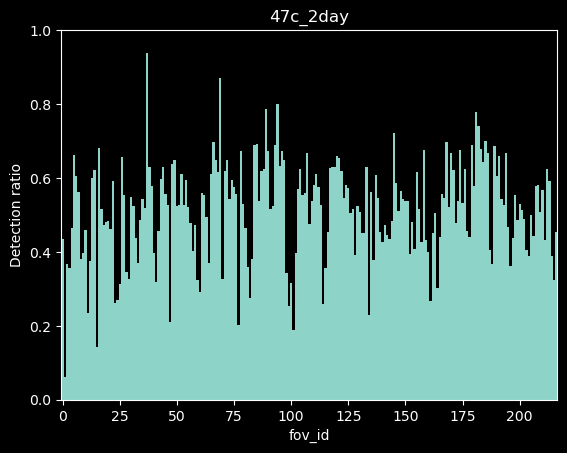

In [27]:
%matplotlib inline
fov_detection_df = pd.DataFrame.from_dict(fov_2_info, orient='index')
fov_detection_df['fov_id'] = fov_2_info.keys()
fov_detection_df['ratio'] = fov_detection_df['num_positive'] / fov_detection_df['num_total']
fov_detection_df = fov_detection_df.set_index('fov_id')

kept_fov_ratios = fov_detection_df['ratio']
plt.figure()
plt.bar(x=kept_fov_ratios.index, height=kept_fov_ratios, width=1)
plt.xlabel('fov_id')
plt.ylabel('Detection ratio')
plt.xlim([0-0.5, len(fov_detection_df)-0.5])
plt.ylim([0,1])
plt.title(os.path.basename(data_folder.strip(r'/')))
plt.show()

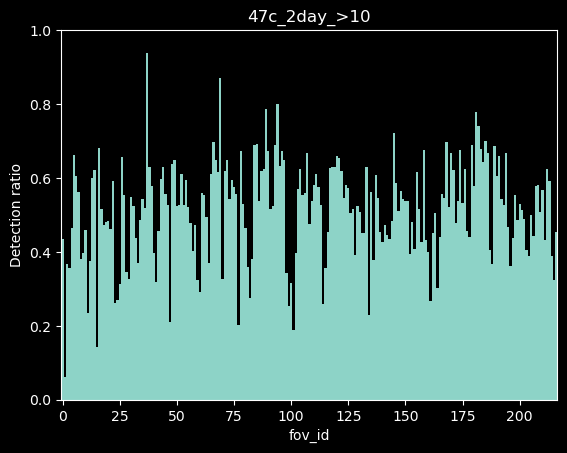

In [28]:
kept_fov_ratios = fov_detection_df['ratio'][fov_detection_df['num_total'] > 10]
plt.figure()
plt.bar(x=kept_fov_ratios.index, height=kept_fov_ratios, width=1)
plt.xlabel('fov_id')
plt.ylabel('Detection ratio')
plt.xlim([0-0.5, len(fov_detection_df)-0.5])
plt.ylim([0,1])
plt.title(os.path.basename(data_folder.strip(r'/'))+'_>10')
plt.show()

In [31]:

_fov_filename = os.path.join(folders[0], fovs[10])
_save_filename = _fov_filename.replace('.dax', '.hdf5')

with h5py.File(_save_filename, 'r') as _f:
    _spots_748 = Spots3D(_f['H0M1/748/spots'][:], pixel_size=[500,107,107])
    _spots_637 = Spots3D(_f['H0M1/637/spots'][:], pixel_size=[500,107,107])
    _im_748 = _f['H0M1/748/im'][:]
    _im_637 = _f['H0M1/637/im'][:]
    _dapi_im = _f['H0M1/405/im'][:]
    _dna_mask = _f['dapi_mask'][:]

<IPython.core.display.Javascript object>


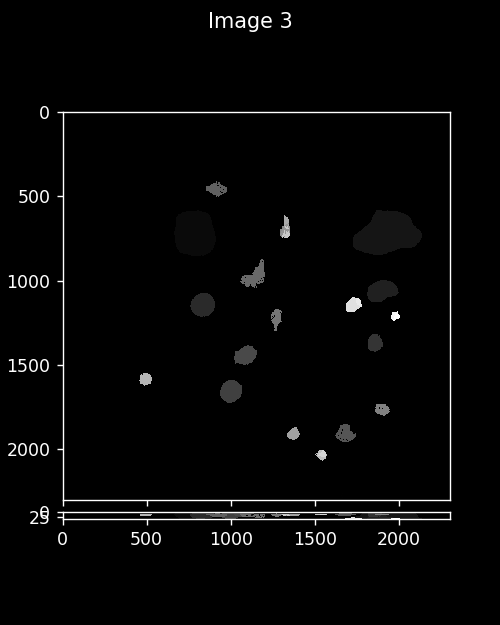

In [33]:
%matplotlib notebook
interactive.imshow_mark_3d([_im_748, _im_637, _dapi_im, _dna_mask])

<IPython.core.display.Javascript object>


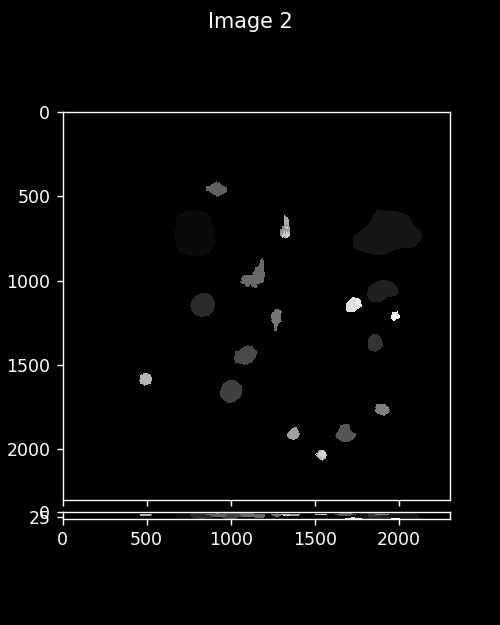

In [36]:
%matplotlib notebook
interactive.imshow_mark_3d([_dapi_im, _dna_mask])

<IPython.core.display.Javascript object>


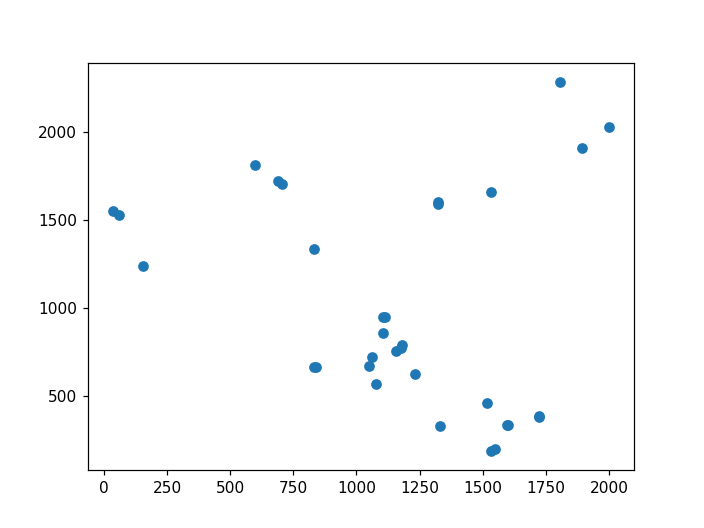

In [46]:
plt.figure()
plt.scatter(kept_spots_637.to_coords()[:,1], kept_spots_637.to_coords()[:,2])